## 0. Configurações Iniciais

### 0.1 Importação de Bibliotecas e Configurações

In [1]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, loguniform
from random import seed, randrange
from math import sqrt
import time
import joblib

from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import NeighbourhoodCleaningRule
from category_encoders import TargetEncoder


# Modelos
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklvq import GMLVQ


import warnings
warnings.filterwarnings('ignore')

# Configurações para visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Garante que a pasta 'modelos' existe
import os
os.makedirs('modelos', exist_ok=True)

### 0.2 Definição de LVQ

In [2]:
class LVQ(GMLVQ):
    def predict(self, X):
        decision_values = self.decision_function(X)
        
        if self.classes_.size == 2:
            return self.classes_[(decision_values > 0).astype(np.int64)]  # Changed from np.int to np.int64
        
        return self.classes_[decision_values.argmax(axis=1)]

## 1. Carregamento dos Dados

Nesta seção, realizamos o carregamento dos dados.

In [3]:
# Carregamento dos dados de treinamento
train_df = pd.read_csv('data/train.csv')

# Separar features e target
X = train_df.drop(columns=['ACTION'])
y = train_df['ACTION']

# (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

## 2. Pré-processamento
Como a fase de Análise de Dados já foi feita anteriormente no arquivo `projeto_analise.ipynb`, vamos para o pré-processamento.

In [4]:
# Lista de colunas que são categorias, mas estão com tipo numérico
categorical_int_cols = [
    'MGR_ID',
    'ROLE_ROLLUP_2',
    'ROLE_DEPTNAME',
    'ROLE_TITLE',
    'ROLE_FAMILY_DESC',
    'ROLE_CODE',
    'RESOURCE'
]
for col in categorical_int_cols:
    X_train[col] = X_train[col].astype(str) # Ou .astype('object')
    X_test[col] = X_test[col].astype(str) # o mesmo no teste!
    
print("Novos tipos de dados em X_train:")
print(X_train[categorical_int_cols].info())

Novos tipos de dados em X_train:
<class 'pandas.core.frame.DataFrame'>
Index: 26215 entries, 10137 to 31226
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   MGR_ID            26215 non-null  object
 1   ROLE_ROLLUP_2     26215 non-null  object
 2   ROLE_DEPTNAME     26215 non-null  object
 3   ROLE_TITLE        26215 non-null  object
 4   ROLE_FAMILY_DESC  26215 non-null  object
 5   ROLE_CODE         26215 non-null  object
 6   RESOURCE          26215 non-null  object
dtypes: object(7)
memory usage: 1.6+ MB
None


### Divisão das colunas em alta e baixa cardinalidade e remoção de colunas.

In [5]:
# Remover as colunas indesejadas
cols_to_remove = ['ROLE_ROLLUP_1', 'ROLE_FAMILY']
X_train_clean = X_train.drop(columns=cols_to_remove, errors='ignore')
X_test_clean = X_test.drop(columns=cols_to_remove, errors='ignore')

In [6]:
low_card_features = [col for col in X_train_clean.columns if X_train_clean[col].nunique() < 450]
high_card_features = [col for col in X_train_clean.columns if X_train_clean[col].nunique() >= 450]

low_card_features_2 = [col for col in X_train.columns if X_train[col].nunique() < 450]
high_card_features_2 = [col for col in X_train.columns if X_train[col].nunique() >= 450]

print("Colunas de baixa e alta cardinalidade em X_train_clean:")
print("Baixa cardinalidade:", low_card_features)
print("Alta cardinalidade:", high_card_features)

print("\nColunas de baixa e alta cardinalidade em X_train:")
print("Baixa cardinalidade:", low_card_features_2)
print("Alta cardinalidade:", high_card_features_2)

Colunas de baixa e alta cardinalidade em X_train_clean:
Baixa cardinalidade: ['ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_CODE']
Alta cardinalidade: ['RESOURCE', 'MGR_ID', 'ROLE_FAMILY_DESC']

Colunas de baixa e alta cardinalidade em X_train:
Baixa cardinalidade: ['ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY', 'ROLE_CODE']
Alta cardinalidade: ['RESOURCE', 'MGR_ID', 'ROLE_FAMILY_DESC']


### Comparação de Estratégias de Pré-processamento

Neste experimento, avaliamos o impacto da remoção de colunas no pré-processamento dos dados. Foram testados dois cenários:

- **Com remoção de colunas:**  
    As colunas `ROLE_ROLLUP_1` e `ROLE_FAMILY` foram removidas antes do pré-processamento.

- **Sem remoção de colunas:**  
    Todas as colunas originais foram mantidas no pré-processamento.

O pré-processador utilizado para ambos os cenários foi:

- **Pré-processador para os modelos:**  
    `OneHotEncoder` para variáveis de baixa cardinalidade (`low_cardinality_features`) e `TargetEncoder` para variáveis de alta cardinalidade (`high_cardinality_features`).

A comparação dos resultados permite avaliar se a exclusão dessas colunas influencia o desempenho dos modelos de classificação.

In [7]:
# Definições de baixa e alta cardinalidade para ambos os conjuntos
low_card_features = [col for col in X_train_clean.columns if X_train_clean[col].nunique() < 450]
high_card_features = [col for col in X_train_clean.columns if X_train_clean[col].nunique() >= 450]

low_card_features_2 = [col for col in X_train.columns if X_train[col].nunique() < 450]
high_card_features_2 = [col for col in X_train.columns if X_train[col].nunique() >= 450]

# Pré-processador para X_train_clean
preprocessor_clean = ColumnTransformer(transformers=[
    ('low_card', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary', min_frequency=0.01), low_card_features),
    ('high_card', TargetEncoder(smoothing=1.0, min_samples_leaf=20), high_card_features)
], remainder='passthrough')

# Pré-processador para X_train (todas as colunas)
preprocessor_full = ColumnTransformer(transformers=[
    ('low_card', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary', min_frequency=0.01), low_card_features_2),
    ('high_card', TargetEncoder(smoothing=1.0, min_samples_leaf=20), high_card_features_2)
], remainder='passthrough')

In [8]:
# Importe o ImbPipeline se ainda não o fez
from imblearn.pipeline import Pipeline as ImbPipeline

def create_pipeline(classifier, use_full=False):
    """
    Cria um pipeline com três etapas:
    1. Pré-processador para transformar os dados.
    2. Reamostrador para balancear os dados (APENAS NO TREINO).
    3. Classificador para realizar a predição.
    
    Parâmetros:
    - classifier: o estimador/classificador a ser usado.
    - use_full: se True, usa preprocessor_full; senão, usa preprocessor_clean.
    """
    preproc = preprocessor_full if use_full else preprocessor_clean
    
    # O reamostrador
    ncr_resampler = NeighbourhoodCleaningRule(
        sampling_strategy='majority',
        n_neighbors=5,
        kind_sel='mode',
        n_jobs=-1
    )
    
    return ImbPipeline(steps=[
        ('preprocessor', preproc),
        ('resampler', ncr_resampler), # A etapa de balanceamento está AQUI
        ('classifier', classifier)
    ])

Aplicando pré-processamento e reamostragem para visualização...
Dados prontos para visualização.

Nova distribuição de classes:
ACTION
1    21546
0     1518
Name: count, dtype: int64
Gerando o gráfico...


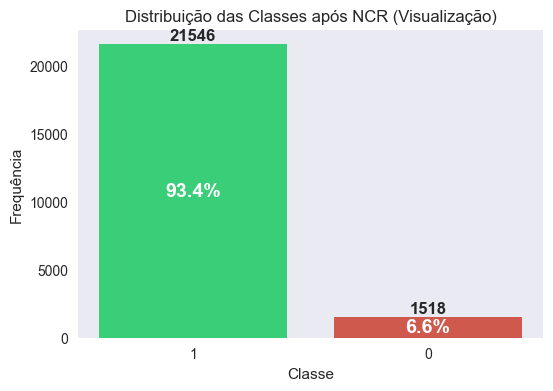

In [9]:
# 1. Crie um pipeline apenas com as etapas de pré-processamento e reamostragem
ncr_resampler_vis = NeighbourhoodCleaningRule(
    sampling_strategy='majority',
    n_neighbors=5,
    kind_sel='mode',
    n_jobs=-1
)

visualization_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor_clean),
    ('resampler', ncr_resampler_vis)
])

# 2. Aplique o pipeline aos dados de treino originais para obter os dados reamostrados
#    Este passo é SOMENTE para a visualização
print("Aplicando pré-processamento e reamostragem para visualização...")
X_vis, y_vis = visualization_pipeline.fit_resample(X_train_clean, y_train)
print("Dados prontos para visualização.")
print("\nNova distribuição de classes:")
print(y_vis.value_counts())

# 3. Use o seu código de plotagem com a nova variável 'y_vis'
print("Gerando o gráfico...")
counts = y_vis.value_counts()
proportions = y_vis.value_counts(normalize=True)

# Visualização gráfica
plt.figure(figsize=(6,4))
bars = plt.bar(counts.index.astype(str), counts.values, color=["#3ACE78", "#CE594C"])
plt.title("Distribuição das Classes após NCR (Visualização)")
plt.xlabel("Classe")
plt.ylabel("Frequência")
for bar, count, prop in zip(bars, counts.values, proportions.values):
    plt.text(
        bar.get_x() + bar.get_width()/2., 
        bar.get_height()/2,
        f'{prop:.1%}', 
        ha='center', va='center', fontweight='bold', color='white', fontsize=14
    )
    plt.text(
        bar.get_x() + bar.get_width()/2., 
        bar.get_height() + 50,
        f'{count}', 
        ha='center', va='bottom', fontweight='bold'
    )
plt.grid(False)
plt.show()

## 5. Seleção de Modelos Fase 

### 5.1 Fase 1

Modelos avaliados nesta fase:

- **K-NN** (K-Nearest Neighbors)
- **Árvore de Decisão** (Decision Tree)
- **Random Forest**
- **SVM** (Support Vector Machine)
- **LVQ** (Learning Vector Quantization)


In [10]:
models = {
    "K-NN": KNeighborsClassifier(),
    "Árvore de Decisão": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM (Kernel RBF)": SVC(random_state=42, max_iter=1000, probability=True),
    "GMLVQ" : LVQ(random_state=42)
}

In [11]:
# Dicionário de métricas que queremos calcular
scoring = {
    'precision_0': make_scorer(precision_score, pos_label=0, zero_division=0),
    'precision_1': make_scorer(precision_score, pos_label=1, zero_division=0),
    'recall_0': make_scorer(recall_score, pos_label=0, zero_division=0),
    'recall_1': make_scorer(recall_score, pos_label=1, zero_division=0),
    'f1_0': make_scorer(f1_score, pos_label=0, zero_division=0),
    'f1_weighted': make_scorer(f1_score, average='weighted', zero_division=0)
}

# Estratégia de validação cruzada estratificada
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Dicionário para armazenar os resultados finais
results_clean = {}
results_full = {}
results_NCR = {}

In [63]:
# Loop para avaliar cada modelo do seu dicionário 'models'
for name, model in models.items():
    print(f"Avaliando : {name}...")
    
    # Criação do Pipeline Simples
    # Etapa 1: 'preprocessor_full' que você já definiu (com OneHotEncoder e TargetEncoder).
    # Etapa 2: O classificador da vez (K-NN, Árvore de Decisão, etc.).
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor_full),
        ('classifier', model)
    ])
    
    # Executa a validação cruzada no pipeline
    # Os dados de treino são os originais e completos: X_train e y_train
    scores = cross_validate(
        pipeline, 
        X_train, 
        y_train,
        cv=cv_strategy, 
        scoring=scoring, 
        n_jobs=-1
    )
    
    # Armazena a média dos resultados
    results_full[name] = {
        'precision_0_media': scores['test_precision_0'].mean(),
        'precision_1_media': scores['test_precision_1'].mean(),
        'recall_0_media': scores['test_recall_0'].mean(),
        'recall_1_media': scores['test_recall_1'].mean(),
        'f1_0_media': scores['test_f1_0'].mean(),
        'f1_weighted_media': scores['test_f1_weighted'].mean()
    }

Avaliando (todas as colunas): K-NN...
Avaliando (todas as colunas): Árvore de Decisão...
Avaliando (todas as colunas): Random Forest...
Avaliando (todas as colunas): SVM (Kernel RBF)...
Avaliando (todas as colunas): GMLVQ...


In [64]:
# Loop para avaliar cada modelo do seu dicionário 'models'
for name, model in models.items():
    print(f"Avaliando X_train_clean: {name}...")
    
    # Criação do Pipeline Simples
    # Etapa 1: 'preprocessor_clean' que você já definiu.
    # Etapa 2: O classificador da vez.
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor_clean),
        ('classifier', model)
    ])
    
    # Executa a validação cruzada no pipeline
    # Os dados de treino são X_train_clean e y_train
    scores = cross_validate(
        pipeline, 
        X_train_clean, 
        y_train,
        cv=cv_strategy, 
        scoring=scoring, 
        n_jobs=-1
    )
    
    # Armazena a média dos resultados
    results_clean[name] = {
        'precision_0_media': scores['test_precision_0'].mean(),
        'precision_1_media': scores['test_precision_1'].mean(),
        'recall_0_media': scores['test_recall_0'].mean(),
        'recall_1_media': scores['test_recall_1'].mean(),
        'f1_0_media': scores['test_f1_0'].mean(),
        'f1_weighted_media': scores['test_f1_weighted'].mean()
    }


Avaliando X_train_clean: K-NN...
Avaliando X_train_clean: Árvore de Decisão...
Avaliando X_train_clean: Random Forest...
Avaliando X_train_clean: SVM (Kernel RBF)...
Avaliando X_train_clean: GMLVQ...


In [69]:
# Loop de avaliação
for name, model in models.items():
    print(f"Avaliando com Resampling (NCR): {name}...")
    
    # Criamos o pipeline com colunas limpas (use_full=False) 
    # e COM reamostragem (use_resampling=True)
    pipeline = create_pipeline(model, use_full=False)
    
    scores = cross_validate(
        pipeline,
        X_train_clean,  # Usamos os dados originais, o pipeline cuida do resto
        y_train,
        cv=cv_strategy,
        scoring=scoring,
        n_jobs=-1
    )
    
    results_NCR[name] = {
        'precision_0_media': scores['test_precision_0'].mean(),
        'precision_1_media': scores['test_precision_1'].mean(),
        'recall_0_media': scores['test_recall_0'].mean(),
        'recall_1_media': scores['test_recall_1'].mean(),
        'f1_0_media': scores['test_f1_0'].mean(),
        'f1_weighted_media': scores['test_f1_weighted'].mean()
    }

Avaliando com Resampling (NCR): K-NN...
Avaliando com Resampling (NCR): Árvore de Decisão...
Avaliando com Resampling (NCR): Random Forest...
Avaliando com Resampling (NCR): SVM (Kernel RBF)...
Avaliando com Resampling (NCR): GMLVQ...


In [65]:
# --- Visualização dos Resultados ---
results_full_df = pd.DataFrame(results_full).T
results_full_df = results_full_df.sort_values(by='f1_0_media', ascending=False)
print("\n" + "=" * 60)
print("       RESULTADO BASELINE (DADOS COMPLETOS E SEM RESAMPLING)")
print("=" * 60)
print(results_full_df)


       RESULTADO BASELINE (DADOS COMPLETOS E SEM RESAMPLING)
                   precision_0_media  precision_1_media  recall_0_media  \
Random Forest               0.576664           0.959505        0.323488   
Árvore de Decisão           0.351197           0.961511        0.376860   
GMLVQ                       0.060664           0.943712        0.387927   
SVM (Kernel RBF)            0.081171           0.941945        0.082455   
K-NN                        0.201639           0.943302        0.028974   

                   recall_1_media  f1_0_media  f1_weighted_media  
Random Forest            0.985140    0.412679           0.939751  
Árvore de Decisão        0.956796    0.362669           0.924598  
GMLVQ                    0.630523    0.104773           0.717522  
SVM (Kernel RBF)         0.915542    0.054342           0.876476  
K-NN                     0.992955    0.050414           0.914388  


In [67]:
# --- Visualização dos Resultados ---
results_clean_df = pd.DataFrame(results_clean).T
results_clean_df = results_clean_df.sort_values(by='f1_0_media', ascending=False)

print("\n" + "=" * 60)
print("     RESULTADO BASELINE (DADOS COM COLUNAS REMOVIDAS E SEM RESAMPLING)")
print("=" * 60)
print(results_clean_df)


     RESULTADO BASELINE (DADOS COM COLUNAS REMOVIDAS E SEM RESAMPLING)
                   precision_0_media  precision_1_media  recall_0_media  \
Random Forest               0.582186           0.957985        0.295813   
Árvore de Decisão           0.358011           0.961601        0.377488   
GMLVQ                       0.058546           0.942704        0.408409   
SVM (Kernel RBF)            0.080119           0.943338        0.125932   
K-NN                        0.201639           0.943302        0.028974   

                   recall_1_media  f1_0_media  f1_weighted_media  
Random Forest            0.986800    0.390896           0.938515  
Árvore de Decisão        0.958133    0.366853           0.925518  
GMLVQ                    0.597874    0.101895           0.689927  
SVM (Kernel RBF)         0.893395    0.072928           0.867102  
K-NN                     0.992955    0.050414           0.914388  


In [82]:
results_NCR_df = pd.DataFrame(results_NCR).T
results_NCR_df = results_NCR_df.sort_values(by='f1_0_media', ascending=False)

print("\n" + "=" * 60)
print("             RESULTADO FINAL DA AVALIAÇÃO COM RESAMPLING")
print("=" * 60)
print(results_NCR_df)


             RESULTADO FINAL DA AVALIAÇÃO COM RESAMPLING
                   precision_0_media  precision_1_media  recall_0_media  \
Random Forest               0.506766           0.961557        0.363668   
Árvore de Decisão           0.291091           0.964867        0.447334   
K-NN                        0.153843           0.946270        0.110701   
GMLVQ                       0.059008           0.942787        0.426076   
SVM (Kernel RBF)            0.046167           0.941616        0.073863   

                   recall_1_media  f1_0_media  f1_weighted_media  
Random Forest            0.978175    0.422521           0.938100  
Árvore de Decisão        0.932826    0.352283           0.914037  
K-NN                     0.962627    0.128246           0.906532  
GMLVQ                    0.581454    0.102941           0.677174  
SVM (Kernel RBF)         0.919059    0.044822           0.876757  


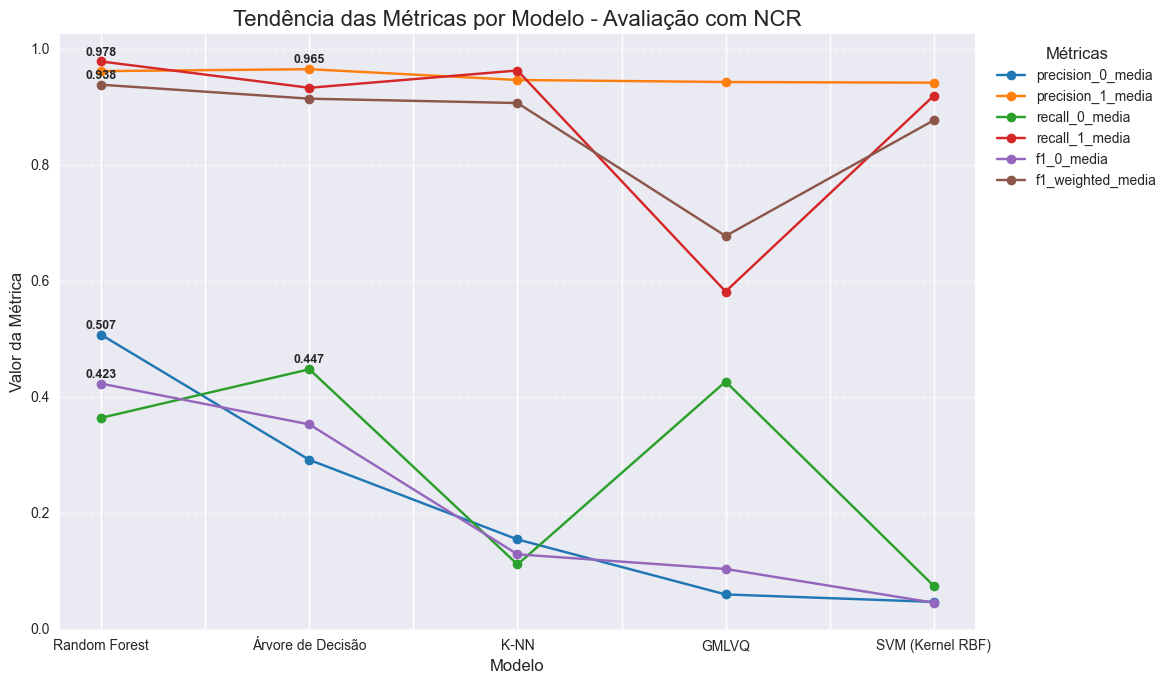

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Dicionário de cores para as MÉTRICAS ---
cores_metricas = {
    'precision_0_media': '#1f77b4',  # Azul
    'precision_1_media': '#ff7f0e',  # Laranja
    'recall_0_media':    '#2ca02c',  # Verde
    'recall_1_media':    '#d62728',  # Vermelho
    'f1_0_media':        '#9467bd',  # Roxo
    'f1_weighted_media': '#8c564b'   # Marrom
}


# --- Criação do Gráfico ---
fig, ax = plt.subplots(figsize=(14, 7))

# Plotamos o DataFrame, passando o novo dicionário de cores
results_NCR_df.plot(
    kind='line',
    marker='o',
    ax=ax,
    color=cores_metricas  
)

# --- Loop para anotar o ponto de maior valor de cada métrica ---
for metrica in results_NCR_df.columns:
    serie_metrica = results_NCR_df[metrica]
    max_valor = serie_metrica.max()
    max_modelo = serie_metrica.idxmax()
    pos_x = list(results_NCR_df.index).index(max_modelo)
    
    ax.text(
        pos_x,
        max_valor + 0.005,
        f'{max_valor:.3f}',
        ha='center',
        va='bottom',
        fontweight='bold',
        fontsize=9
    )

# --- Customização final do Gráfico ---
plt.title('Tendência das Métricas por Modelo - Avaliação com NCR', fontsize=16)
plt.ylabel('Valor da Métrica', fontsize=12)
plt.xlabel('Modelo', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Métricas', bbox_to_anchor=(1.01, 1), loc='upper left') 
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

### 5.2 Fase 2

- **Rede Neural MLP (Multilayer Perceptron)**
- **Comitê de Redes Neurais Artificiais**
- **Comitê Heterogêneo (Stacking)**
- **XGBoost**
- **LightGBM**


In [92]:

models_fase2 = {
    "MLP": MLPClassifier(random_state=42, max_iter=300),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42, verbose=-1)
    }

# --- Comitê de Redes Neurais (Voting) ---
mlp1 = MLPClassifier(random_state=1, max_iter=300)
mlp2 = MLPClassifier(random_state=2, max_iter=300)
mlp3 = MLPClassifier(random_state=3, max_iter=300)
voting_mlp = VotingClassifier(
    estimators=[('mlp1', mlp1), ('mlp2', mlp2), ('mlp3', mlp3)],
    voting='soft',
    n_jobs=-1
)

# --- Comitê Heterogêneo (Stacking) ---
estimators_stacking = [
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('mlp', MLPClassifier(random_state=42, max_iter=300))
]
stacking_committee = StackingClassifier(
    estimators=estimators_stacking,
    final_estimator=RandomForestClassifier(random_state=43),
    cv=cv_strategy,
    n_jobs=-1
)

# Dicionário com os modelos de comitê para avaliação
committee_models = {
    "Comitê MLPs (Voting)": voting_mlp,
    "Comitê Heterogêneo (Stacking)": stacking_committee
}


results_fase2 = {}

In [93]:
# Loop para avaliar cada modelo da Fase 2
for name, model in models_fase2.items():
    print(f"Avaliando modelo baseline: {name}...")


    pipeline = create_pipeline(model, use_full=False)

    # Executa a validação cruzada no pipeline com os dados limpos
    scores = cross_validate(
        pipeline,
        X_train_clean,
        y_train,
        cv=cv_strategy,
        scoring=scoring,
        n_jobs=-1
    )

    # Armazena a média dos resultados
    results_fase2[name] = {
        'precision_0_media': scores['test_precision_0'].mean(),
        'precision_1_media': scores['test_precision_1'].mean(),
        'recall_0_media': scores['test_recall_0'].mean(),
        'recall_1_media': scores['test_recall_1'].mean(),
        'f1_0_media': scores['test_f1_0'].mean(),
        'f1_weighted_media': scores['test_f1_weighted'].mean()
    }

Avaliando modelo baseline: MLP...
Avaliando modelo baseline: XGBoost...
Avaliando modelo baseline: LightGBM...


In [94]:
# Loop para avaliar cada modelo de comitês
for name, model in committee_models.items():
    print(f"Avaliando modelo baseline: {name}...")

    pipeline = create_pipeline(model, use_full=False)

    # Executa a validação cruzada no pipeline com os dados limpos
    scores = cross_validate(
        pipeline,
        X_train_clean,
        y_train,
        cv=cv_strategy,
        scoring=scoring,
        n_jobs=-1
    )

    # Armazena a média dos resultados
    results_fase2[name] = {
        'precision_0_media': scores['test_precision_0'].mean(),
        'precision_1_media': scores['test_precision_1'].mean(),
        'recall_0_media': scores['test_recall_0'].mean(),
        'recall_1_media': scores['test_recall_1'].mean(),
        'f1_0_media': scores['test_f1_0'].mean(),
        'f1_weighted_media': scores['test_f1_weighted'].mean()
    }

Avaliando modelo baseline: Comitê MLPs (Voting)...
Avaliando modelo baseline: Comitê Heterogêneo (Stacking)...


In [95]:
# --- Visualização dos Resultados em DataFrame ---
results_fase2_df = pd.DataFrame(results_fase2).T
results_fase2_df = results_fase2_df.sort_values(by='f1_0_media', ascending=False)

print("\n" + "=" * 80)
print("             RESULTADO BASELINE DA FASE 2 COM RESAMPLING")
print("=" * 80)
print(results_fase2_df)


             RESULTADO BASELINE DA FASE 2 COM RESAMPLING
                               precision_0_media  precision_1_media  \
XGBoost                                 0.441154           0.966299   
Comitê Heterogêneo (Stacking)           0.412748           0.967174   
LightGBM                                0.382511           0.954011   
Comitê MLPs (Voting)                    0.411197           0.951146   
MLP                                     0.401984           0.950580   

                               recall_0_media  recall_1_media  f1_0_media  \
XGBoost                              0.452536        0.964570    0.445925   
Comitê Heterogêneo (Stacking)        0.470347        0.958699    0.438540   
LightGBM                             0.233871        0.976718    0.289137   
Comitê MLPs (Voting)                 0.177239        0.984451    0.246252   
MLP                                  0.166696        0.985018    0.234184   

                               f1_weighted_media  
X

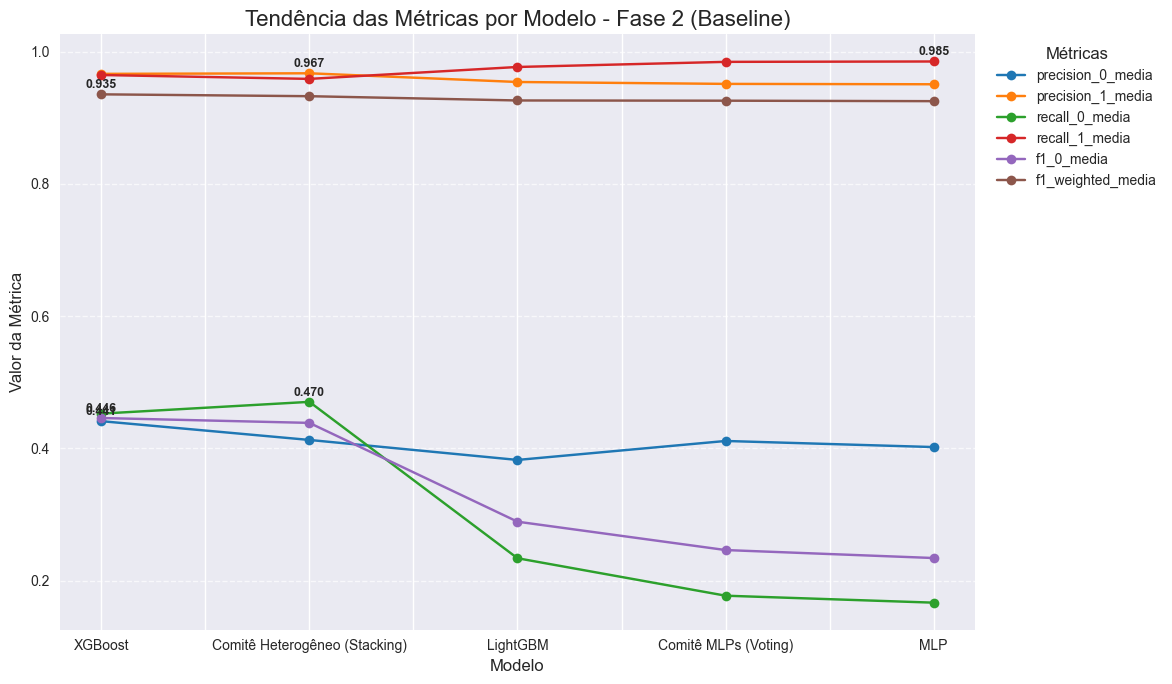

In [98]:
# --- Dicionário de cores para as MÉTRICAS ---
cores_metricas = {
    'precision_0_media': '#1f77b4',  # Azul
    'precision_1_media': '#ff7f0e',  # Laranja
    'recall_0_media':    '#2ca02c',  # Verde
    'recall_1_media':    '#d62728',  # Vermelho
    'f1_0_media':        '#9467bd',  # Roxo
    'f1_weighted_media': '#8c564b'   # Marrom
}

# --- Criação do Gráfico ---
fig, ax = plt.subplots(figsize=(14, 7))

results_fase2_df.plot(
    kind='line',
    marker='o',
    ax=ax,
    color=cores_metricas  
)

# --- Loop para anotar o ponto de maior valor de cada métrica ---
for metrica in results_fase2_df.columns:
    serie_metrica = results_fase2_df[metrica]
    
    max_valor = serie_metrica.max()
    max_modelo = serie_metrica.idxmax()
    
    pos_x = list(results_fase2_df.index).index(max_modelo)
    
    ax.text(
        pos_x,
        max_valor + 0.005,
        f'{max_valor:.3f}',
        ha='center',
        va='bottom',
        fontweight='bold',
        fontsize=9
    )

# --- Customização final do Gráfico ---
plt.title('Tendência das Métricas por Modelo - Fase 2 (Baseline)', fontsize=16)
plt.ylabel('Valor da Métrica', fontsize=12)
plt.xlabel('Modelo', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Métricas', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

## 6. Busca de Hiperparâmetros

### 6.1 Fase 1

Modelos avaliados nesta fase:

- **K-NN** (K-Nearest Neighbors)
- **Árvore de Decisão** (Decision Tree)
- **SVM** (Support Vector Machine)
- **Random Forest**
- **LVQ** (Learning Vector Quantization)


In [12]:
# --- Dicionário com as Distribuições de Hiperparâmetros ---
param_distributions = {
    "K-NN": {
        'classifier__n_neighbors': randint(3, 30),
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan']
    },
    "Árvore de Decisão": {
        'classifier__max_depth': randint(3, 21),
        'classifier__min_samples_split': randint(2, 11),
        'classifier__min_samples_leaf': randint(1, 11),
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__class_weight': ['balanced', None]
    },
    "Random Forest": {
        'classifier__n_estimators': randint(50, 301),
        'classifier__max_depth': randint(3, 21),
        'classifier__min_samples_split': randint(2, 11),
        'classifier__min_samples_leaf': randint(1, 11),
        'classifier__max_features': ['sqrt', 'log2', None],
        'classifier__class_weight': ['balanced', None],
        'classifier__bootstrap': [True, False]
    },
    "SVM (Kernel RBF)": {
        'classifier__C': loguniform(0.1, 100),
        'classifier__gamma': loguniform(0.001, 1),
        'classifier__kernel': ['rbf'],
        'classifier__class_weight': ['balanced', None]
    },
    "GMLVQ": {
        'classifier__prototype_n_per_class': randint(1, 10), # Corrigido de 'prototypes_per_class'
        'classifier__relevance_regularization': loguniform(1e-4, 1.0),
        'classifier__activation_type': ['sigmoid', 'soft+'],
        'classifier__solver_type': ['lbfgs', 'sgd']
    }
}

In [13]:
# Vamos criar um dicionário temporário apenas com o modelo GMLVQ para o teste
model_to_test = {
    "GMLVQ": models["GMLVQ"]
}

# Loop de otimização para o GMLVQ
for name, model in model_to_test.items():
    print(f"--- Testando a otimização do modelo: {name} ---")

    # Cria o pipeline com pré-processamento e reamostragem
    pipeline = create_pipeline(model, use_full=False)

    # Configura a busca aleatória
    search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_distributions[name],
        n_iter=3,
        cv=cv_strategy,
        scoring=scoring['f1_0'],
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    # Executa a busca nos dados de treino
    search.fit(X_train_clean, y_train)

    # Salva o melhor modelo encontrado
    best_model = search.best_estimator_
    print(f"\nBusca concluída com sucesso!")
    print(f"Melhores hiperparâmetros para {name}:")
    print(search.best_params_)

    # Salva o modelo otimizado
    joblib.dump(best_model, f'modelos/{name}_otimizado.pkl')
    print(f"\nModelo '{name}' otimizado e salvo.")

    # --- Avaliação Final no Conjunto de Teste ---
    print(f"Gerando Matriz de Confusão para '{name}' no conjunto de teste...")
    y_pred = best_model.predict(X_test_clean)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f'Matriz de Confusão Final - {name} (Otimizado)')
    plt.show()
    print("-" * 80)


--- Testando a otimização do modelo: GMLVQ ---
Fitting 10 folds for each of 10 candidates, totalling 100 fits


KeyboardInterrupt: 

--- Otimizando o modelo: K-NN ---
Fitting 10 folds for each of 10 candidates, totalling 100 fits

Melhores hiperparâmetros para K-NN:
{'classifier__metric': 'manhattan', 'classifier__n_neighbors': 8, 'classifier__weights': 'distance'}

Modelo 'K-NN' otimizado e salvo.
Gerando Matriz de Confusão para 'K-NN' no conjunto de teste...


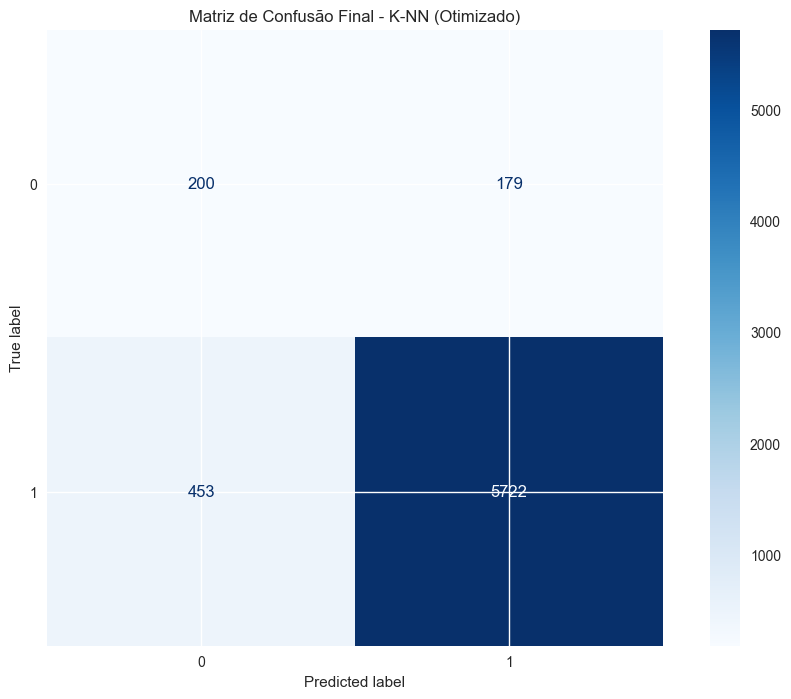

--------------------------------------------------------------------------------
--- Otimizando o modelo: Árvore de Decisão ---
Fitting 10 folds for each of 10 candidates, totalling 100 fits

Melhores hiperparâmetros para Árvore de Decisão:
{'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': 16, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10}

Modelo 'Árvore de Decisão' otimizado e salvo.
Gerando Matriz de Confusão para 'Árvore de Decisão' no conjunto de teste...


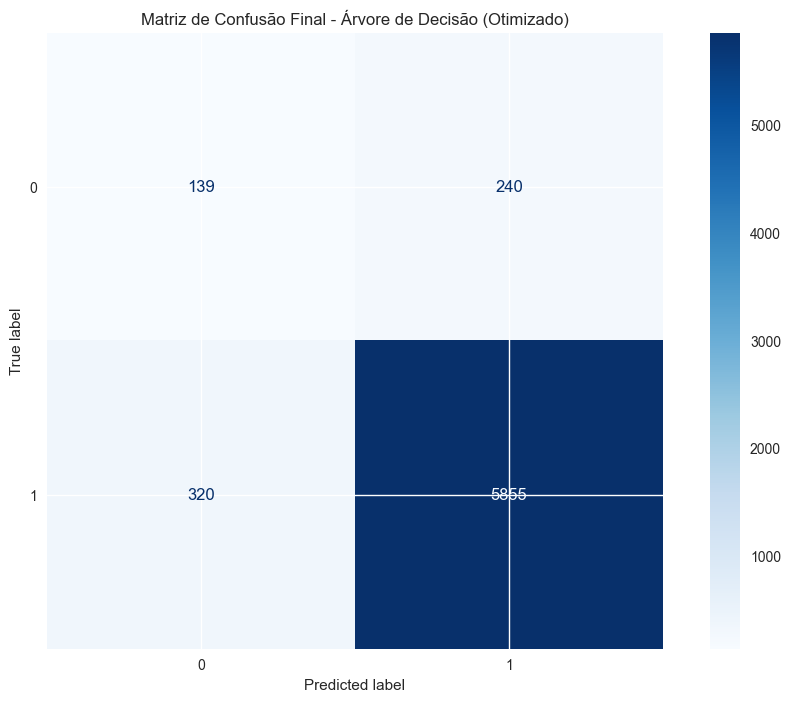

--------------------------------------------------------------------------------
--- Otimizando o modelo: Random Forest ---
Fitting 10 folds for each of 10 candidates, totalling 100 fits

Melhores hiperparâmetros para Random Forest:
{'classifier__bootstrap': False, 'classifier__class_weight': None, 'classifier__max_depth': 20, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 63}

Modelo 'Random Forest' otimizado e salvo.
Gerando Matriz de Confusão para 'Random Forest' no conjunto de teste...


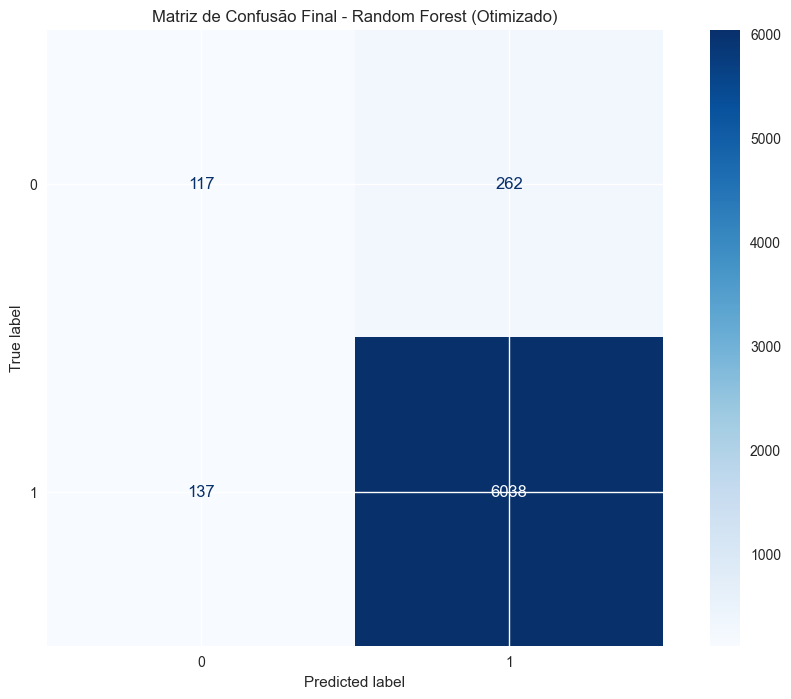

--------------------------------------------------------------------------------
--- Otimizando o modelo: SVM (Kernel RBF) ---
Fitting 10 folds for each of 10 candidates, totalling 100 fits

Melhores hiperparâmetros para SVM (Kernel RBF):
{'classifier__C': np.float64(0.115279871282324), 'classifier__class_weight': None, 'classifier__gamma': np.float64(0.146553541187277), 'classifier__kernel': 'rbf'}

Modelo 'SVM (Kernel RBF)' otimizado e salvo.
Gerando Matriz de Confusão para 'SVM (Kernel RBF)' no conjunto de teste...


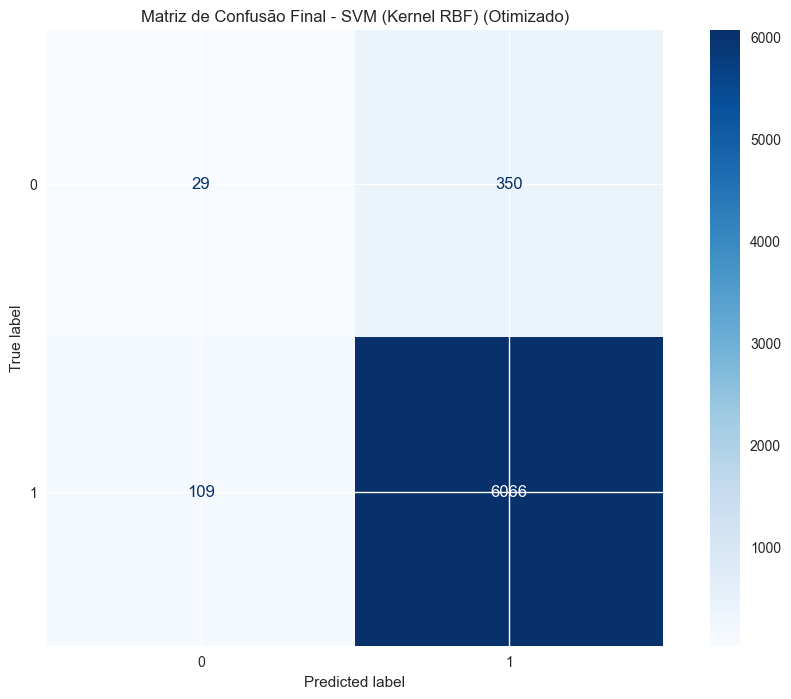

--------------------------------------------------------------------------------
--- Otimizando o modelo: GMLVQ ---
Fitting 10 folds for each of 10 candidates, totalling 100 fits


ValueError: Invalid parameter 'activation' for estimator LVQ(random_state=42). Valid parameters are: ['activation_params', 'activation_type', 'discriminant_params', 'discriminant_type', 'distance_params', 'distance_type', 'force_all_finite', 'prototype_init', 'prototype_n_per_class', 'random_state', 'relevance_init', 'relevance_n_components', 'relevance_normalization', 'relevance_regularization', 'solver_params', 'solver_type'].

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import joblib

# Dicionário para armazenar os melhores modelos encontrados
best_models_fase1 = {}

# Loop de otimização para os modelos da Fase 1
for name, model in models.items():
    print(f"--- Otimizando o modelo: {name} ---")

    # Cria o pipeline com pré-processamento e reamostragem
    pipeline = create_pipeline(model, use_full=False)

    # Configura a busca aleatória
    search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_distributions[name],
        n_iter=10,          # Executa 10 iterações
        cv=cv_strategy,
        scoring=scoring['f1_0'], # Otimiza pelo F1-score da classe 0
        n_jobs=-1,
        random_state=42,
        verbose=1           # Exibe o progresso
    )

    # Executa a busca nos dados de treino originais
    search.fit(X_train_clean, y_train)

    # Salva o melhor modelo encontrado pela busca
    best_model = search.best_estimator_
    print(f"\nMelhores hiperparâmetros para {name}:")
    print(search.best_params_)

    # Armazena o melhor modelo no dicionário
    best_models_fase1[name] = best_model

    # Salva o modelo otimizado em um arquivo
    joblib.dump(best_model, f'modelos/{name}_otimizado.pkl')
    print(f"\nModelo '{name}' otimizado e salvo.")

    # --- Avaliação Final no Conjunto de Teste ---
    print(f"Gerando Matriz de Confusão para '{name}' no conjunto de teste...")
    y_pred = best_model.predict(X_test_clean)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f'Matriz de Confusão Final - {name} (Otimizado)')
    plt.show()
    print("-" * 80)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Otimização dos modelos da Fase 1 com n_iter=10 e matriz de confusão final


# Dicionário para armazenar os melhores modelos e resultados
best_models_fase1 = {}
confusion_matrices = {}

for name, model in models.items():
    print(f"Otimização: {name}")
    if name in param_distributions:
        # RandomizedSearchCV apenas para modelos com espaço de busca definido
        pipeline = create_
        search = RandomizedSearchCV(
            pipeline,
            param_distributions=param_distributions[name],
            n_iter=10,
            cv=cv_strategy,
            scoring=scoring['f1_0'],
            n_jobs=-1,
            random_state=42,
            verbose=1
        )
        search.fit(X_ncr_clean, y_ncr_clean)
        best_model = search.best_estimator_
        print("Melhores hiperparâmetros:", search.best_params_)
    else:
        # LVQ não tem espaço de busca, apenas pipeline padrão
        best_model = Pipeline([
            ('preprocessor', preprocessor_clean),
            ('classifier', model)
        ])
        best_model.fit(X_ncr_clean, y_ncr_clean)
        print("Modelo LVQ treinado com parâmetros padrão.")

    best_models_fase1[name] = best_model

    # Previsão e matriz de confusão
    y_pred = best_model.predict(X_test_clean)
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices[name] = cm
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Matriz de Confusão - {name} (Otimizado)')
    plt.show()

Otimização: K-NN
Fitting 10 folds for each of 10 candidates, totalling 100 fits


KeyboardInterrupt: 

In [ ]:
# Dicionário para armazenar os resultados de todas as iterações
all_iterations_results = {}

# Número de iterações para cada modelo
n_iterations = 20

# Loop principal para otimizar cada modelo
for name, model in models.items():
    # Pula modelos que não estão no nosso dicionário de busca (como o LVQ)
    if name not in param_distributions:
        continue

    print(f"--> Otimizando o modelo: {name}")
    print(f"    Executando {n_iterations} iterações...")
    
    # Inicializa listas para armazenar resultados de cada iteração
    iteration_scores = []
    iteration_params = []
    iteration_times = []
    
    # Loop para executar múltiplas iterações
    for iteration in range(n_iterations):
        print(f"    Iteração {iteration + 1}/{n_iterations}", end=" - ")
        start_time = time.time()

        # Cria o pipeline com o pré-processador + classificador
        pipeline = Pipeline([('classifier', model)])

        # Ajusta o n_iter para Random Forest e SVM
        if name in ["Random Forest", "SVM (Kernel RBF)"]:
            n_iter = 3
        else:
            n_iter = 20

        # Configura a busca aleatória de hiperparâmetros
        # Usa uma seed diferente para cada iteração para garantir diversidade
        random_search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=param_distributions[name],
            n_iter=n_iter,          # Número de combinações a testar por iteração
            cv=cv_strategy,         # Usando a validação cruzada estratificada
            scoring='f1_0_media',      # Focando na métrica roc auc
            n_jobs=-1,              # Utiliza todos os processadores
            random_state=42 + iteration,  # Seed diferente para cada iteração
            verbose=0               # Mantido em 0 para uma saída limpa
        )

        # Executa a busca com os dados de treino
        random_search.fit(X_ncr, y_ncr)
        
        # Calcula o tempo de duração da busca
        duration = time.time() - start_time
        
        # Armazena os resultados desta iteração
        iteration_scores.append(random_search.best_score_)
        iteration_params.append(random_search.best_params_)
        iteration_times.append(duration)
        
        print(f"ROC AUC: {random_search.best_score_:.4f} ({duration:.1f}s)")
        
        # Salva o modelo se o score for melhor que o último
        if iteration==0 or random_search.best_score_ > best_score:  # Apenas salva se o score for maior que o último score
            best_score = random_search.best_score_  # Atualiza o melhor score
            joblib.dump(random_search.best_estimator_, f'modelos/{name}_otimizado.pkl')
            print(f"Modelo {name} salvo em 'modelos/{name}_otimizado.pkl'\n")
        
    
    # Armazena todos os resultados para este modelo
    all_iterations_results[name] = {
        'scores': iteration_scores,
        'params': iteration_params,
        'times': iteration_times,
        'best_score': max(iteration_scores),
        'best_params': iteration_params[np.argmax(iteration_scores)],
        'mean_score': np.mean(iteration_scores),
        'std_score': np.std(iteration_scores)
    }
    
    # Resumo dos resultados para este modelo
    print(f"    Melhor ROC AUC: {max(iteration_scores):.4f}")
    print(f"    ROC AUC Médio: {np.mean(iteration_scores):.4f} ± {np.std(iteration_scores):.4f}")
    print(f"    Tempo total: {sum(iteration_times):.1f} segundos")
    print("-" * 70)

--> Otimizando o modelo: K-NN
    Executando 20 iterações...
    Iteração 1/20 - ROC AUC: 0.9052 (76.6s)
    Iteração 2/20 - ROC AUC: 0.9052 (57.8s)
    Iteração 3/20 - ROC AUC: 0.9048 (59.1s)
    Iteração 4/20 - ROC AUC: 0.8972 (53.2s)
    Iteração 5/20 - ROC AUC: 0.8972 (41.8s)
    Iteração 6/20 - ROC AUC: 0.9013 (75.0s)
    Iteração 7/20 - ROC AUC: 0.8972 (55.5s)
    Iteração 8/20 - ROC AUC: 0.9053 (50.7s)
    Iteração 9/20 - ROC AUC: 0.8986 (44.7s)
    Iteração 10/20 - ROC AUC: 0.9053 (47.6s)
    Iteração 11/20 - ROC AUC: 0.9048 (69.8s)
    Iteração 12/20 - ROC AUC: 0.9060 (60.6s)
    Iteração 13/20 - ROC AUC: 0.9053 (71.1s)
    Iteração 14/20 - ROC AUC: 0.9060 (54.6s)
    Iteração 15/20 - ROC AUC: 0.9013 (50.0s)
    Iteração 16/20 - ROC AUC: 0.9053 (62.4s)
    Iteração 17/20 - ROC AUC: 0.9060 (70.2s)
    Iteração 18/20 - ROC AUC: 0.9053 (79.4s)
    Iteração 19/20 - ROC AUC: 0.8972 (52.2s)
    Iteração 20/20 - ROC AUC: 0.9041 (62.3s)
    Melhor ROC AUC: 0.9060
    ROC AUC Médio: 0.

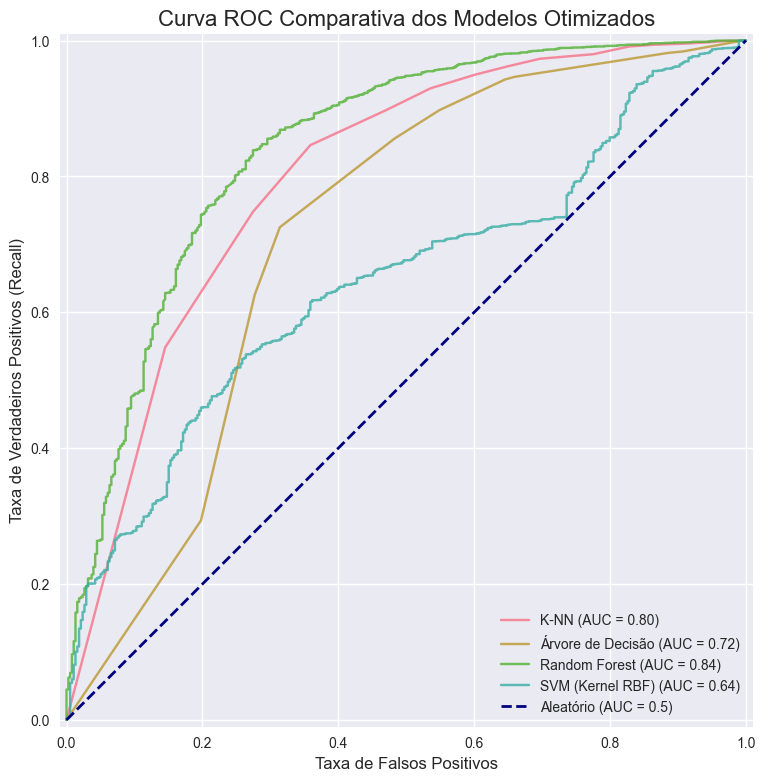

In [ ]:
# Extrai os melhores modelos da busca
best_models = {name: result['best_estimator'] for name, result in search_results.items()}

# Configura a figura
plt.figure(figsize=(12, 9))
ax = plt.gca()

# Itera sobre os melhores modelos para plotar cada curva
for name, model_pipeline in best_models.items():
    RocCurveDisplay.from_estimator(
    model_pipeline, X_test_clean, y_test, name=name, ax=ax, curve_kwargs={'alpha': 0.8}
)

# Adiciona a linha de referência (classificador aleatório)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatório (AUC = 0.5)')

# Customiza o gráfico
plt.title('Curva ROC Comparativa dos Modelos Otimizados', fontsize=16)
plt.xlabel('Taxa de Falsos Positivos', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos (Recall)', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True)

### 6.2 Fase 2

Nesta etapa, foram avaliados os seguintes modelos:

- **Rede Neural MLP (Multilayer Perceptron)**
- **Comitê de Redes Neurais Artificiais (Voting MLPs)**
- **Comitê Heterogêneo (Stacking)**
- **XGBoost**
- **LightGBM**



In [ ]:
# --- Dicionário de Hiperparâmetros para os modelos da FASE 2  ---
param_distributions_fase2 = {
    "XGBoost": {
        'classifier__n_estimators': randint(50, 300),
        'classifier__max_depth': randint(3, 15),
        'classifier__learning_rate': loguniform(0.01, 0.3),
        'classifier__subsample': loguniform(0.6, 1.0),
        'classifier__colsample_bytree': loguniform(0.6, 1.0),
        'classifier__gamma': loguniform(1e-4, 5.0),
        'classifier__reg_alpha': loguniform(1e-4, 1.0),  
        'classifier__reg_lambda': loguniform(1e-4, 1.0) 
    },
    "LightGBM": {
        'classifier__n_estimators': randint(50, 300),
        'classifier__max_depth': randint(3, 15),
        'classifier__learning_rate': loguniform(0.01, 0.3),
        'classifier__num_leaves': randint(20, 100),        
        'classifier__subsample': loguniform(0.6, 1.0),      
        'classifier__colsample_bytree': loguniform(0.6, 1.0),
        'classifier__reg_alpha': loguniform(1e-4, 1.0),     
        'classifier__reg_lambda': loguniform(1e-4, 1.0)     
    },
    "MLP": {
        'classifier__hidden_layer_sizes': [
            (50,), (100,),               # 1 Camada
            (50, 50), (100, 50),         # 2 Camadas
            (100, 50, 25),               # 3 Camadas (nova)
            (50, 50, 50),                # 3 Camadas (nova)
            (100, 100, 50)               # 3 Camadas (nova)
        ],
        'classifier__activation': ['tanh', 'relu'],
        'classifier__solver': ['adam', 'sgd'],
        'classifier__alpha': loguniform(1e-5, 1e-1), # Regularização
        'classifier__learning_rate': ['constant', 'adaptive']
    }
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import joblib

# Modelos da Fase 2 para otimização
models_fase2 = {
    "MLP": MLPClassifier(random_state=42, max_iter=300),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42, verbose=-1)
}

# Dicionário para armazenar os melhores modelos encontrados
best_models_fase2 = {}

# Loop de otimização para os modelos da Fase 2
for name, model in models_fase2.items():
    print(f"--- Otimizando o modelo: {name} ---")

    # Cria o pipeline com pré-processamento e reamostragem
    pipeline = create_pipeline(model, use_full=False, use_resampling=True)

    # Configura a busca aleatória
    search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_distributions_fase2[name],
        n_iter=10,          # Executa 10 iterações
        cv=cv_strategy,
        scoring=scoring['f1_0'], # Otimiza pelo F1-score da classe 0
        n_jobs=-1,
        random_state=42,
        verbose=1           # Exibe o progresso
    )

    # Executa a busca nos dados de treino originais
    search.fit(X_train_clean, y_train)

    # Salva o melhor modelo encontrado pela busca
    best_model = search.best_estimator_
    print(f"\nMelhores hiperparâmetros para {name}:")
    print(search.best_params_)

    # Armazena o melhor modelo no dicionário
    best_models_fase2[name] = best_model

    # Salva o modelo otimizado em um arquivo
    joblib.dump(best_model, f'modelos/{name}_otimizado.pkl')
    print(f"\nModelo '{name}' otimizado e salvo.")

    # --- Avaliação Final no Conjunto de Teste ---
    print(f"Gerando Matriz de Confusão para '{name}' no conjunto de teste...")
    y_pred = best_model.predict(X_test_clean)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f'Matriz de Confusão Final - {name} (Otimizado)')
    plt.show()
    print("-" * 80)

In [ ]:
# Busca Randomizada para XGBoost com scoring f1_0
search_xgb = RandomizedSearchCV(
    pipeline_xgb,
    param_distributions=param_dist_xgb,
    n_iter=20,
    cv=cv_strategy,
    scoring=scoring['f1_0'],
    n_jobs=-1,
    random_state=42,
    verbose=2
)
search_xgb.fit(X_ncr_clean, y_ncr_clean)
print("Melhores hiperparâmetros XGBoost:", search_xgb.best_params_)
print("Melhor F1_0 XGBoost:", search_xgb.best_score_)

# Salvar modelo XGBoost otimizado
joblib.dump(search_xgb.best_estimator_, 'modelos/xgboost_otimizado.pkl')

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Melhores hiperparâmetros XGBoost: {'classifier__colsample_bytree': np.float64(0.9038942995623728), 'classifier__gamma': np.float64(0.00022403260998810274), 'classifier__learning_rate': np.float64(0.28691395365453726), 'classifier__max_depth': 10, 'classifier__n_estimators': 178, 'classifier__reg_alpha': np.float64(0.0006235377135673159), 'classifier__reg_lambda': np.float64(0.00010521761868451144), 'classifier__subsample': np.float64(0.9100397210499223)}
Melhor F1_0 XGBoost: 0.4914067878762962
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Melhores hiperparâmetros LightGBM: {'classifier__colsample_bytree': np.float64(0.6180690932801379), 'classifier__learning_rate': np.float64(0.19030368381735815), 'classifier__max_depth': 6, 'classifier__n_estimators': 153, 'classifier__reg_alpha': np.float64(0.06796578090758151), 'classifier__reg_lambda': np.float64(0.00012087541473056971), 'classifier__subsample': np.floa

['modelos/lightgbm_otimizado.pkl']

In [ ]:
# Busca Randomizada para LightGBM com scoring f1_0
search_lgbm = RandomizedSearchCV(
    pipeline_lgbm,
    param_distributions=param_dist_lgbm,
    n_iter=20,
    cv=cv_strategy,
    scoring=scoring['f1_0'],
    n_jobs=-1,
    random_state=42,
    verbose=2
)
search_lgbm.fit(X_ncr_clean, y_ncr_clean)
print("Melhores hiperparâmetros LightGBM:", search_lgbm.best_params_)
print("Melhor F1_0 LightGBM:", search_lgbm.best_score_)

# Salvar modelo LightGBM otimizado
joblib.dump(search_lgbm.best_estimator_, 'modelos/lightgbm_otimizado.pkl')

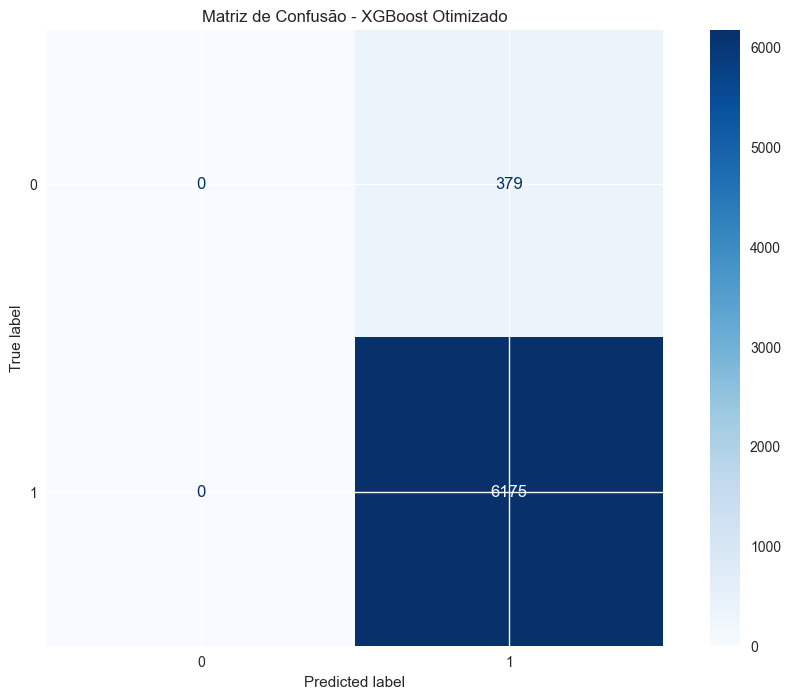

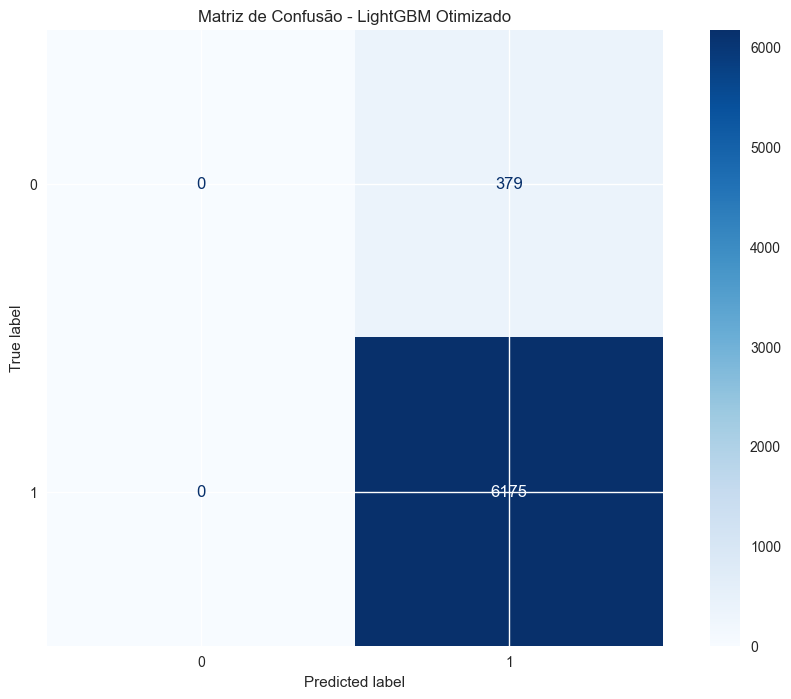

In [ ]:

# Carregar modelos otimizados
xgb_otimizado = joblib.load('modelos/xgboost_otimizado.pkl')
lgbm_otimizado = joblib.load('modelos/lightgbm_otimizado.pkl')

# Prever e plotar matriz de confusão para XGBoost
y_pred_xgb = xgb_otimizado.predict(X_test_clean)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp_xgb.plot(cmap='Blues')
plt.title('Matriz de Confusão - XGBoost Otimizado')
plt.show()

# Prever e plotar matriz de confusão para LightGBM
y_pred_lgbm = lgbm_otimizado.predict(X_test_clean)
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
disp_lgbm = ConfusionMatrixDisplay(confusion_matrix=cm_lgbm)
disp_lgbm.plot(cmap='Blues')
plt.title('Matriz de Confusão - LightGBM Otimizado')
plt.show()